# Vehicle Listings Correlation EDA

This notebook explores the `autos_random_50k_cleaned.csv` dataset with a focus on understanding how the available variables correlate with each other, especially the relationship between vehicle attributes and listing price.

## How to Use This Notebook

- Install dependencies if needed: `pip install pandas numpy seaborn matplotlib` (add `scipy` if you want to compute Cramer's V or other advanced statistics).
- Update `DATA_PATH` below if the CSV lives in a different relative location.
- Execute the notebook sequentially; each section builds on the previous one.
- The correlation exploration is split into numeric vs. categorical handling so you can adapt it for additional analyses.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
DATA_PATH = "../Data/autos_random_50k_cleaned.csv"

df = pd.read_csv(DATA_PATH)
print(f"Rows: {df.shape[0]:,}\nColumns: {df.shape[1]}")
df.head()

Rows: 37,866
Columns: 18


,Unnamed: 0,date_crawled,car_name,price_EUR,ab_test,vehicle_type,registration_year,transmission,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen
0,1,2016-04-02 14:51,Astra_G_Cabrio_Turbo_235_PS,5200,test,cabrio,2002,manuell,235,astra,125000,5,Unknown,opel,nein,2016-04-02 0:00,47652,2016-04-06 13:17
1,2,2016-03-19 18:36,Fiat_Grande_Punto_1.2_8V__MIT_2_JAHREN_GARANTIE,3400,test,kleinwagen,2006,manuell,65,andere,125000,5,benzin,fiat,nein,2016-03-19 0:00,66538,2016-04-07 7:15
2,3,2016-03-09 20:59,Volvo_XC60_D5_AWD_Aut.,5200,test,suv,2009,automatik,220,xc_reihe,150000,3,diesel,volvo,ja,2016-03-09 0:00,72762,2016-03-16 5:46
3,4,2016-03-26 15:55,Kombi_Technisch_super_in_Schuss,750,test,kombi,2000,manuell,112,mondeo,150000,12,benzin,ford,Unknown,2016-03-26 0:00,39446,2016-03-26 15:55
4,5,2016-03-29 14:47,Audi_A4_1.9_TDI_quattro_Delphingrau,3522,test,limousine,2004,manuell,131,a4,150000,7,diesel,audi,nein,2016-03-29 0:00,51373,2016-03-29 14:47


## Initial Quality Checks

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37866 entries, 0 to 37865
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          37866 non-null  int64 
 1   date_crawled        37866 non-null  object
 2   car_name            37866 non-null  object
 3   price_EUR           37866 non-null  int64 
 4   ab_test             37866 non-null  object
 5   vehicle_type        37866 non-null  object
 6   registration_year   37866 non-null  int64 
 7   transmission        37866 non-null  object
 8   power_ps            37866 non-null  int64 
 9   model               37866 non-null  object
 10  odometer_km         37866 non-null  int64 
 11  registration_month  37866 non-null  int64 
 12  fuel_type           37866 non-null  object
 13  brand               37866 non-null  object
 14  unrepaired_damage   37866 non-null  object
 15  ad_created          37866 non-null  object
 16  postal_code         37

In [4]:
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]

Series([], dtype: int64)

In [5]:
describe_numeric = df.select_dtypes(include=[np.number]).describe().T
describe_numeric[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]

,mean,std,min,25%,50%,75%,max
Unnamed: 0,25020.837215,14457.964236,1.0,12499.5,25026.0,37601.25,49998.0
price_EUR,6838.213595,11615.915258,500.0,1700.0,3950.0,8500.00,820000.0
registration_year,2003.529314,6.725368,1929.0,2000.0,2004.0,2008.00,2016.0
power_ps,129.625363,64.633507,1.0,86.0,116.0,156.00,1403.0
odometer_km,124270.717794,39764.869422,5000.0,100000.0,150000.0,150000.00,150000.0
registration_month,6.396820,3.338199,1.0,4.0,6.0,9.00,12.0
postal_code,51743.524613,25656.493782,1067.0,31368.0,50998.0,72469.00,99998.0


## Feature Preparation

Cleaning ensures the correlation results are meaningful by aligning types and handling non-numeric values.

In [6]:
date_columns = ["date_crawled", "ad_created", "last_seen"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors="coerce")

numeric_targets = [
    "price_EUR",
    "power_ps",
    "odometer_km",
    "registration_year",
    "registration_month",
    "postal_code"
]
for col in numeric_targets:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Map binary categories to numeric values when appropriate
binary_maps = {
    "unrepaired_damage": {"nein": 0, "ja": 1}
}
for col, mapping in binary_maps.items():
    if col in df.columns:
        df[col] = df[col].map(mapping)

# Derive date-based features for additional correlation insights
df["days_listed"] = (df["last_seen"] - df["ad_created"]).dt.days
df["days_to_last_seen"] = (df["last_seen"] - df["date_crawled"]).dt.days
df["listing_year"] = df["ad_created"].dt.year

df.head()

,Unnamed: 0,date_crawled,car_name,price_EUR,ab_test,vehicle_type,registration_year,transmission,power_ps,model,odometer_km,registration_month,fuel_type,brand,unrepaired_damage,ad_created,postal_code,last_seen,days_listed,days_to_last_seen,listing_year
0,1,2016-04-02 14:51:00,Astra_G_Cabrio_Turbo_235_PS,5200,test,cabrio,2002,manuell,235,astra,125000,5,Unknown,opel,0.0,2016-04-02,47652,2016-04-06 13:17:00,4,3,2016
1,2,2016-03-19 18:36:00,Fiat_Grande_Punto_1.2_8V__MIT_2_JAHREN_GARANTIE,3400,test,kleinwagen,2006,manuell,65,andere,125000,5,benzin,fiat,0.0,2016-03-19,66538,2016-04-07 07:15:00,19,18,2016
2,3,2016-03-09 20:59:00,Volvo_XC60_D5_AWD_Aut.,5200,test,suv,2009,automatik,220,xc_reihe,150000,3,diesel,volvo,1.0,2016-03-09,72762,2016-03-16 05:46:00,7,6,2016
3,4,2016-03-26 15:55:00,Kombi_Technisch_super_in_Schuss,750,test,kombi,2000,manuell,112,mondeo,150000,12,benzin,ford,NaN,2016-03-26,39446,2016-03-26 15:55:00,0,0,2016
4,5,2016-03-29 14:47:00,Audi_A4_1.9_TDI_quattro_Delphingrau,3522,test,limousine,2004,manuell,131,a4,150000,7,diesel,audi,0.0,2016-03-29,51373,2016-03-29 14:47:00,0,0,2016


## Numeric Correlations

In [7]:
numeric_df = df.select_dtypes(include=[np.number])
corr_numeric = numeric_df.corr(method="pearson")
corr_numeric

,Unnamed: 0,price_EUR,registration_year,power_ps,odometer_km,registration_month,unrepaired_damage,postal_code,days_listed,days_to_last_seen,listing_year
Unnamed: 0,1.000000,-0.001592,0.004805,0.000046,0.003784,0.003848,-0.006727,-0.002415,0.008182,0.008286,-0.006147
price_EUR,-0.001592,1.000000,0.267753,0.467123,-0.347364,-0.013573,-0.102146,0.058650,0.081046,0.081437,0.000592
registration_year,0.004805,0.267753,1.000000,0.160061,-0.344867,-0.001162,-0.088085,0.028274,0.045964,0.044602,-0.004180
power_ps,0.000046,0.467123,0.160061,1.000000,-0.005445,0.011046,-0.036705,0.061900,0.059593,0.060628,0.002753
odometer_km,0.003784,-0.347364,-0.344867,-0.005445,1.000000,0.008503,0.086688,-0.026958,-0.082994,-0.080962,0.007014
registration_month,0.003848,-0.013573,-0.001162,0.011046,0.008503,1.000000,0.001090,-0.003879,-0.009454,-0.008439,0.005229
unrepaired_damage,-0.006727,-0.102146,-0.088085,-0.036705,0.086688,0.001090,1.000000,-0.004193,-0.051569,-0.049874,0.001664
postal_code,-0.002415,0.058650,0.028274,0.061900,-0.026958,-0.003879,-0.004193,1.000000,0.031017,0.031781,0.005769
days_listed,0.008182,0.081046,0.045964,0.059593,-0.082994,-0.009454,-0.051569,0.031017,1.000000,0.986231,-0.083899
days_to_last_seen,0.008286,0.081437,0.044602,0.060628,-0.080962,-0.008439,-0.049874,0.031781,0.986231,1.000000,-0.003387


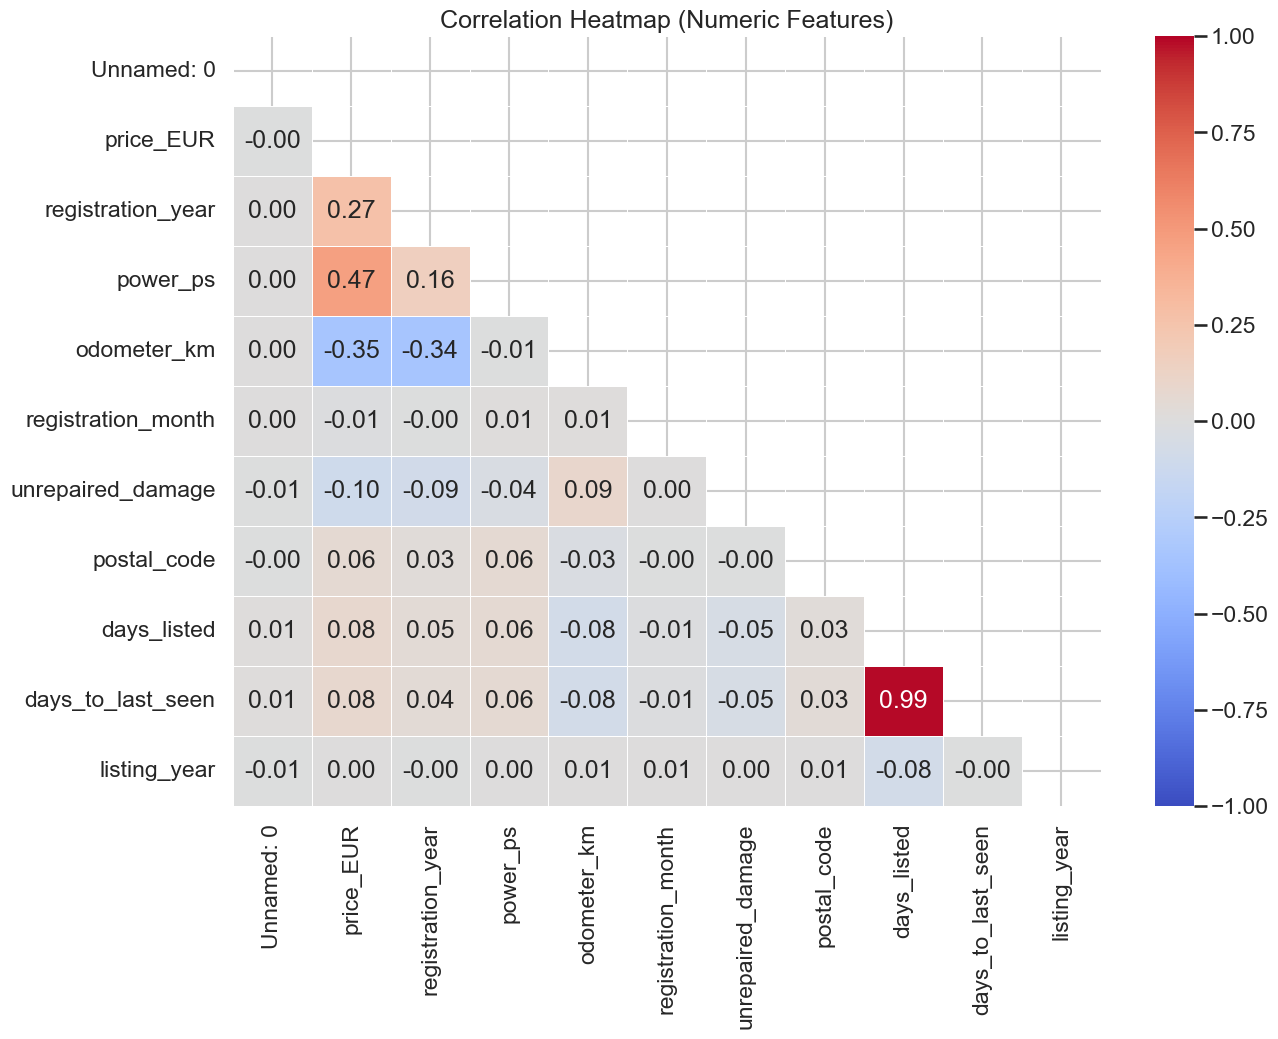

In [8]:
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_numeric, dtype=bool))
sns.heatmap(
    corr_numeric,
    mask=mask,
    cmap="coolwarm",
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [9]:
price_corr = corr_numeric["price_EUR"].drop("price_EUR").sort_values(key=np.abs, ascending=False)
price_corr.head(10)

power_ps              0.467123
odometer_km          -0.347364
registration_year     0.267753
unrepaired_damage    -0.102146
days_to_last_seen     0.081437
days_listed           0.081046
postal_code           0.058650
registration_month   -0.013573
Unnamed: 0           -0.001592
listing_year          0.000592
Name: price_EUR, dtype: float64

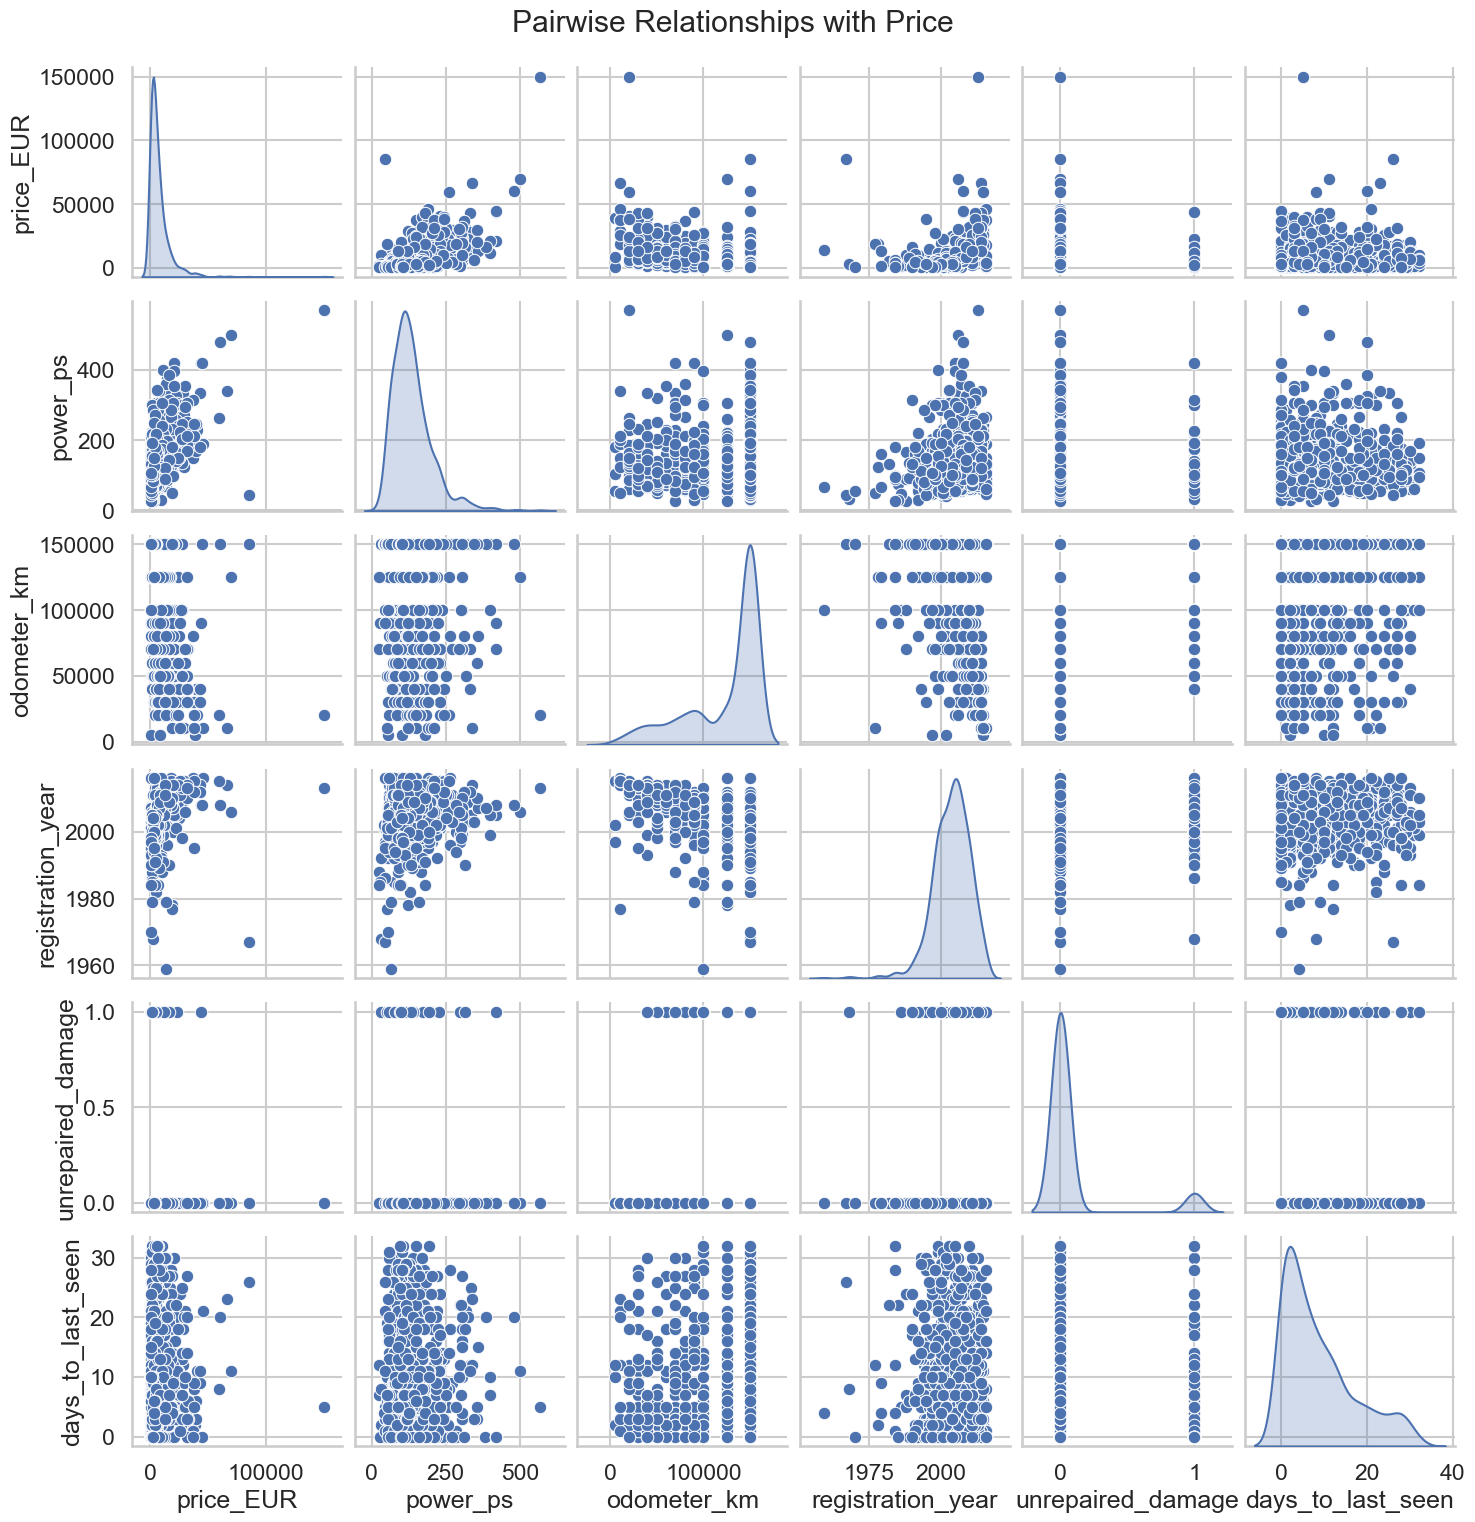

In [10]:
top_numeric_features = price_corr.head(5).index.tolist()
sample_for_plot = df[["price_EUR", *top_numeric_features]].dropna().sample(n=1000, random_state=42)

sns.pairplot(sample_for_plot, diag_kind="kde")
plt.suptitle("Pairwise Relationships with Price", y=1.02)
plt.show()

## Categorical Influence on Price

Categorical variables need encoding to evaluate their linear relationship with price. One-hot encoding provides a quick view, while alternatives like target encoding or mutual information can be added for deeper insight.

In [11]:
high_cardinality = {"car_name", "model"}
categorical_cols = df.select_dtypes(include="object").columns.difference(high_cardinality)

encoded_cats = pd.get_dummies(df[categorical_cols], drop_first=True, dtype=int)
encoded_df = pd.concat([df[["price_EUR"]], encoded_cats], axis=1).dropna(subset=["price_EUR"])

corr_encoded = encoded_df.corr()["price_EUR"].drop("price_EUR")
top_categorical_signals = corr_encoded.reindex(corr_encoded.abs().sort_values(ascending=False).index)
top_categorical_signals.head(15)

brand_porsche              0.314096
transmission_automatik     0.212990
transmission_manuell      -0.210016
vehicle_type_kleinwagen   -0.157882
vehicle_type_coupe         0.138174
fuel_type_diesel           0.129370
vehicle_type_suv           0.128749
vehicle_type_cabrio        0.114261
fuel_type_benzin          -0.106366
brand_sonstige_autos       0.098688
brand_opel                -0.090077
brand_audi                 0.079222
brand_renault             -0.067689
brand_bmw                  0.066149
brand_mercedes_benz        0.064654
Name: price_EUR, dtype: float64

## Optional: Association Strength Between Categorical Features

Use Cramer's V to evaluate associations between categorical variables. This requires `scipy` for the chi-squared statistic.

In [13]:
from itertools import combinations
from math import sqrt
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return sqrt((chi2 / n) / (min(k - 1, r - 1)))

categorical_pairs = combinations(categorical_cols, 2)
cramers_results = []
for col_x, col_y in categorical_pairs:
    try:
        score = cramers_v(df[col_x], df[col_y])
        cramers_results.append({"feature_x": col_x, "feature_y": col_y, "cramers_v": score})
    except ValueError:
        continue

cramers_df = pd.DataFrame(cramers_results)
cramers_df.sort_values("cramers_v", ascending=False).head(10)

,feature_x,feature_y,cramers_v
5,brand,transmission,0.319277
6,brand,vehicle_type,0.263786
8,fuel_type,vehicle_type,0.207265
9,transmission,vehicle_type,0.183329
7,fuel_type,transmission,0.131321
4,brand,fuel_type,0.124903
0,ab_test,brand,0.027986
3,ab_test,vehicle_type,0.016307
1,ab_test,fuel_type,0.012452
2,ab_test,transmission,0.006707


## Next Steps

- Validate whether extreme prices or registration years should be trimmed before modeling.
- Explore non-linear relationships (e.g., tree-based feature importance, mutual information).
- Segment the data (e.g., by `vehicle_type`) and recompute correlations within each slice to uncover context-specific relationships.

# Explicit correlations

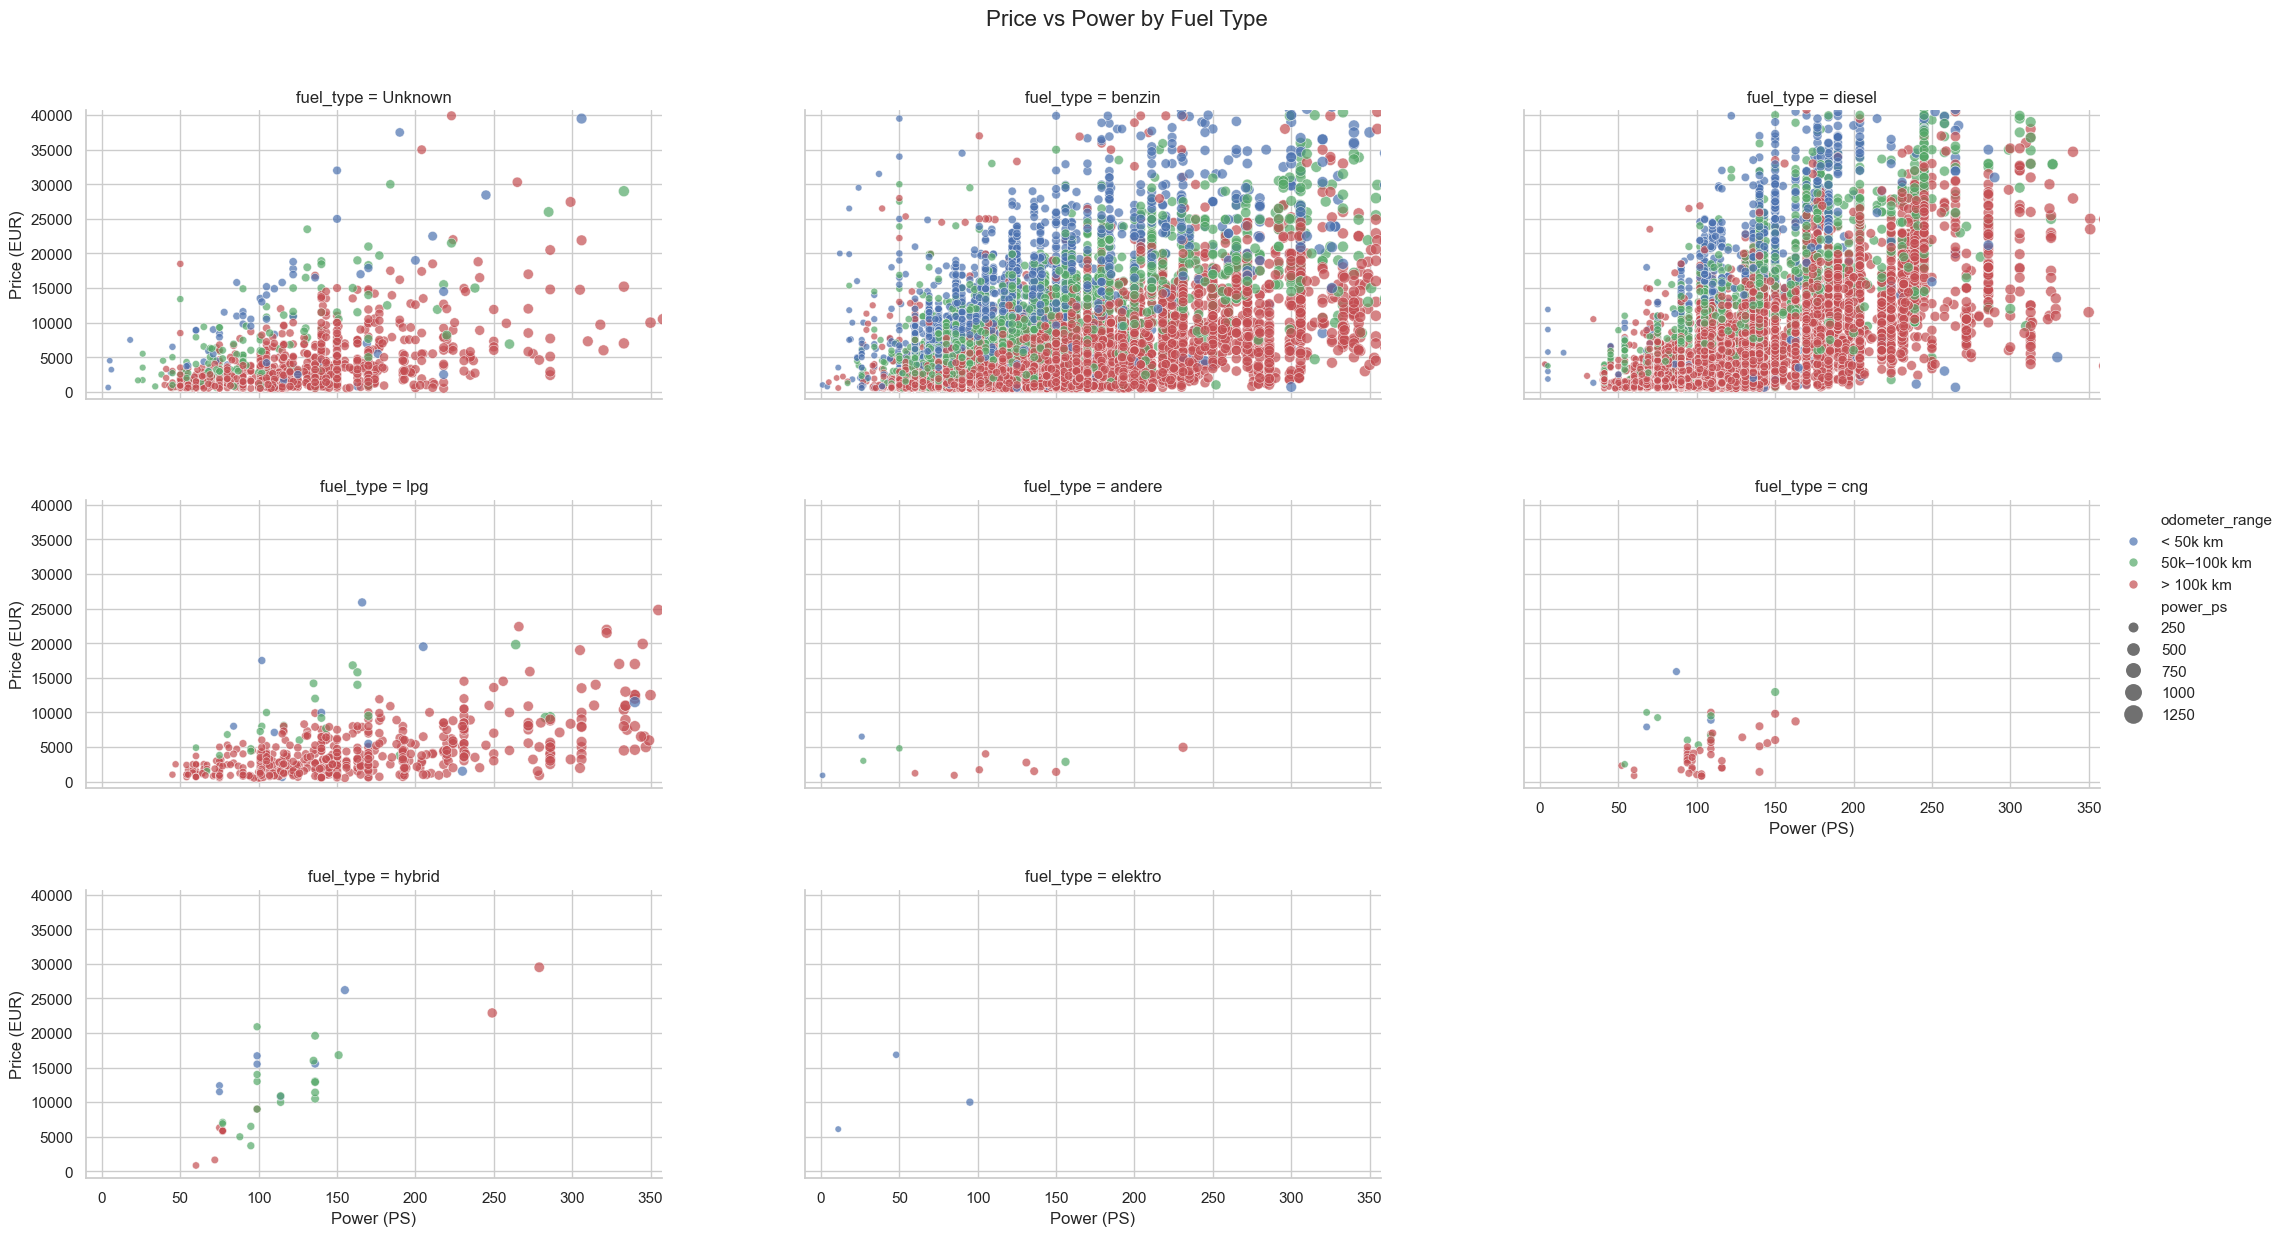

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sns.set(style="whitegrid")

# 1) Prepara el dataset
plot_df = df.dropna(subset=["price_EUR", "power_ps", "odometer_km", "fuel_type"]).copy()

# 2) Filtra los 5 fuel types más comunes
top5_fuels = plot_df["fuel_type"].value_counts().index
filtered_df = plot_df[plot_df["fuel_type"].isin(top5_fuels)].copy()

# 3) Crea rangos del odómetro (3 bins)
bins = [0, 50000, 100000, np.inf]
labels = ["< 50k km", "50k–100k km", "> 100k km"]
filtered_df["odometer_range"] = pd.cut(filtered_df["odometer_km"], bins=bins, labels=labels)

# 4) Define paleta de colores para los rangos
palette = {
    "< 50k km": "#4C72B0",     # azul
    "50k–100k km": "#55A868",  # verde
    "> 100k km": "#C44E52"     # rojo
}

# 5) Define límites comunes
xmax = filtered_df["power_ps"].quantile(0.99)
ymax = filtered_df["price_EUR"].quantile(0.99)

# 6) Gráfica tipo faceta (bubble plot por fuel_type)
g = sns.relplot(
    data=filtered_df,
    x="power_ps", y="price_EUR",
    hue="odometer_range",
    col="fuel_type", col_wrap=3,
    kind="scatter",
    size="power_ps", sizes=(20, 200),  # opcional: burbujas proporcionales a potencia
    alpha=0.7,
    palette=palette,
    height=4.2, aspect=1.7
)

# 7) Configuración estética general
g.set(
    xlim=(-10, xmax*1.05),
    ylim=(-1000, ymax*1.05),
    xlabel="Power (PS)",
    ylabel="Price (EUR)"
)

g.fig.subplots_adjust(top=0.90, right=0.92, wspace=0.25, hspace=0.35)
g.fig.suptitle("Price vs Power by Fuel Type ", fontsize=16)
plt.show()


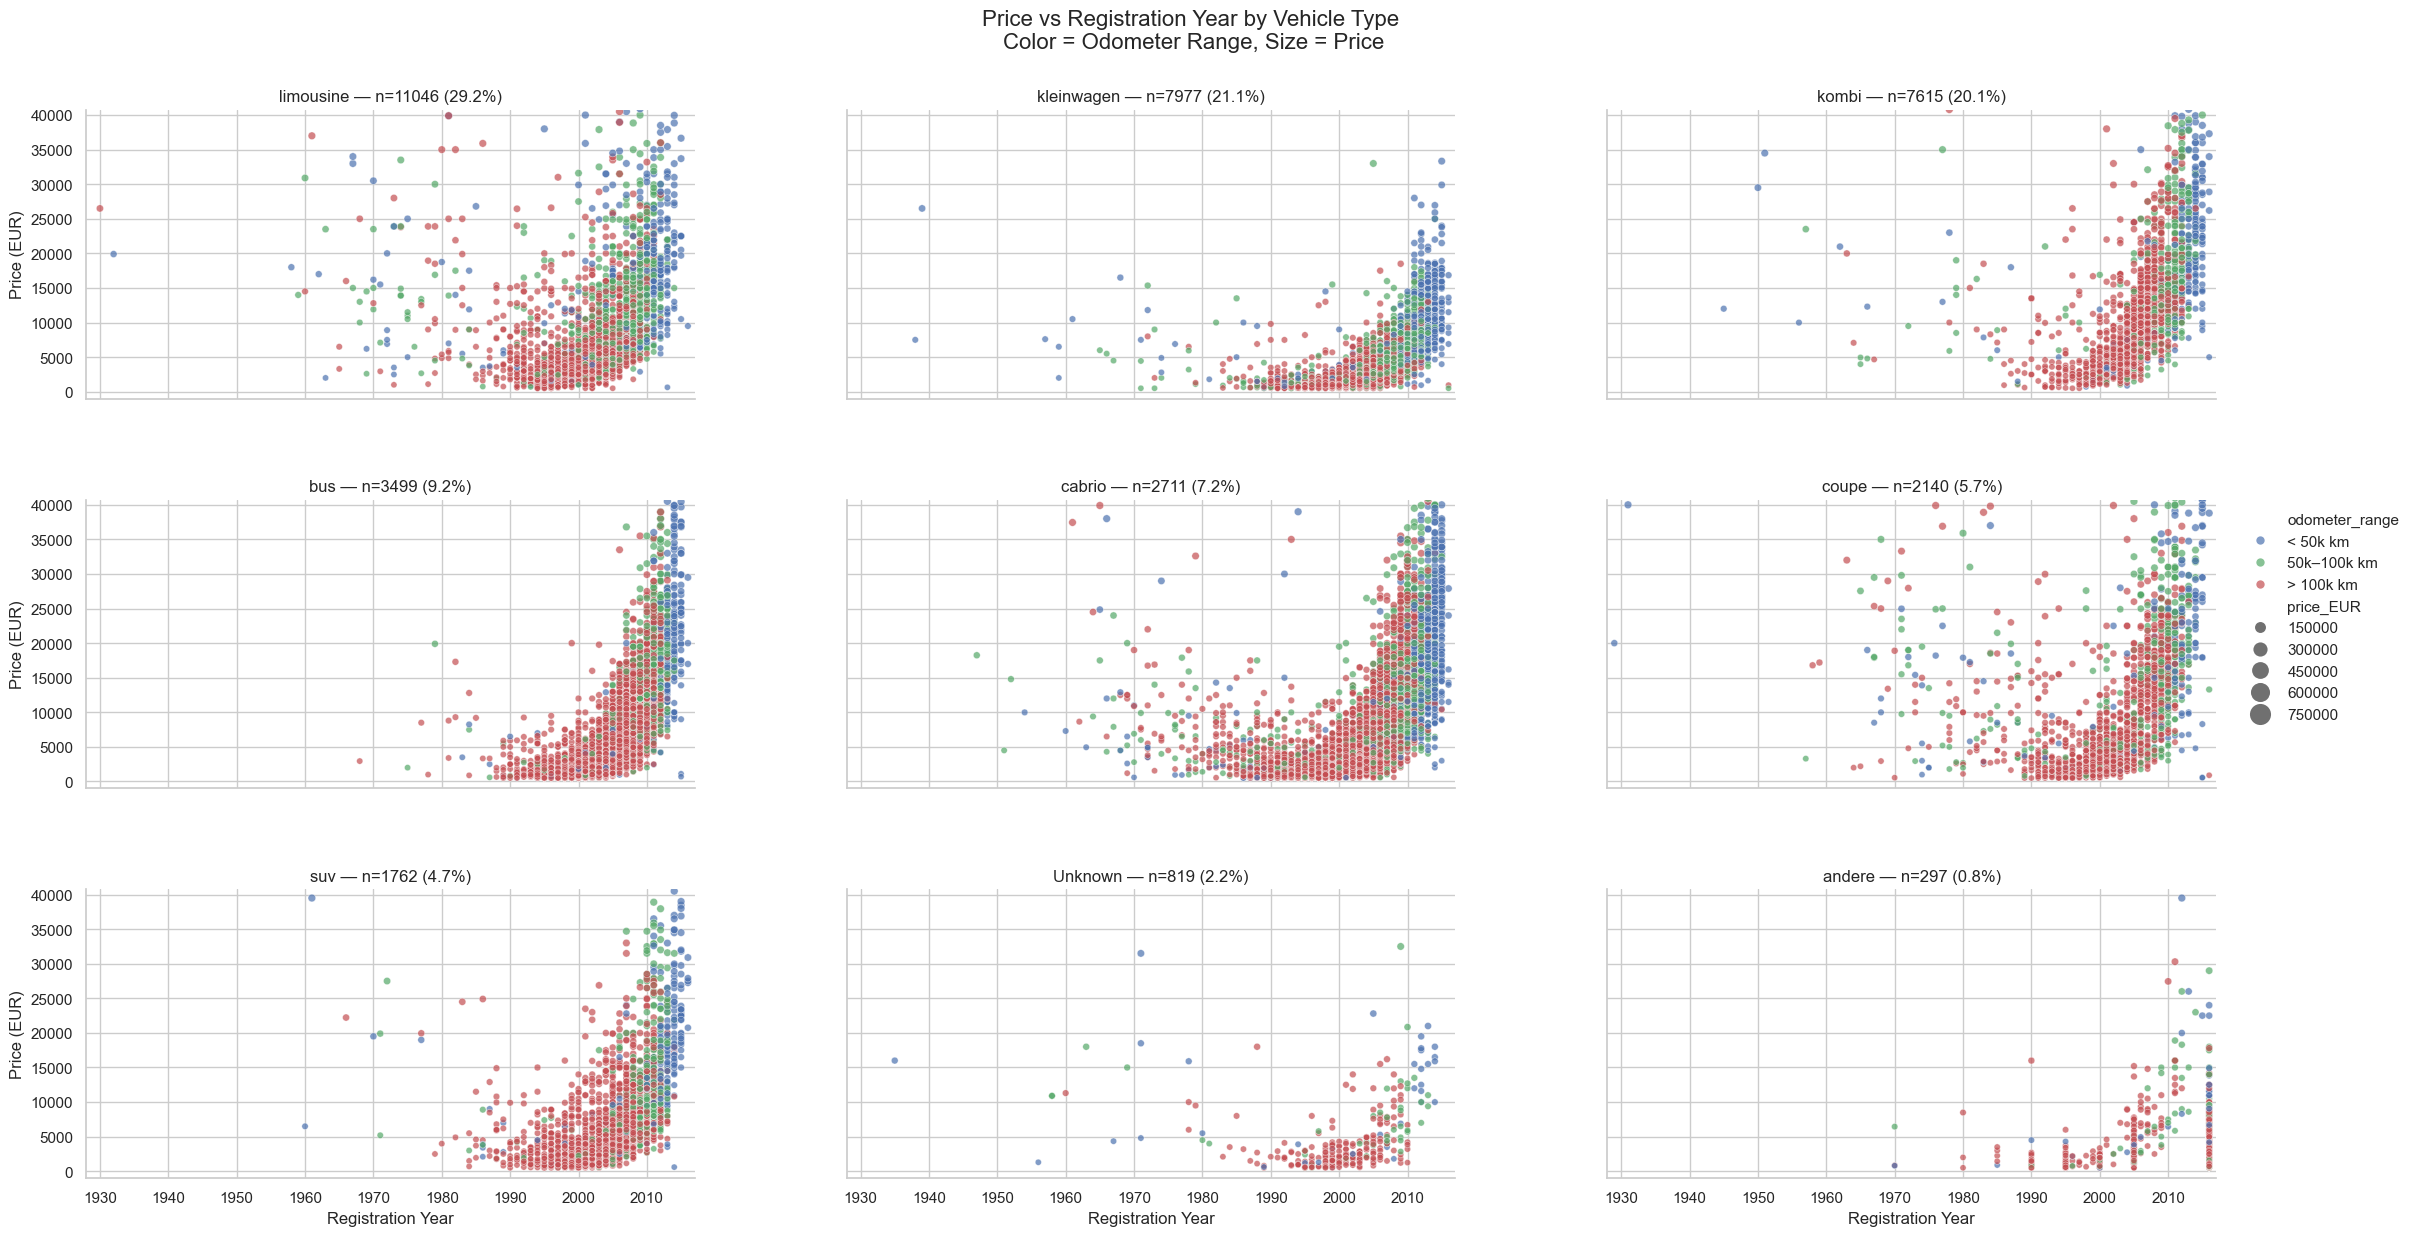

In [33]:
sns.set(style="whitegrid")

# 1️⃣ Preparar datos
plot_df = df.dropna(subset=["price_EUR", "registration_year", "odometer_km", "vehicle_type"]).copy()

# 2️⃣ Filtrar los 5 tipos de vehículo más frecuentes
top5_types = plot_df["vehicle_type"].value_counts().index
filtered_df = plot_df[plot_df["vehicle_type"].isin(top5_types)].copy()

# 3️⃣ Crear rangos de odómetro (3 categorías)
bins = [0, 50000, 100000, np.inf]
labels = ["< 50k km", "50k–100k km", "> 100k km"]
filtered_df["odometer_range"] = pd.cut(filtered_df["odometer_km"], bins=bins, labels=labels)

# 4️⃣ Asignar paleta de colores para los rangos
palette = {
    "< 50k km": "#4C72B0",     # Azul
    "50k–100k km": "#55A868",  # Verde
    "> 100k km": "#C44E52"     # Rojo
}

# 5️⃣ Límites comunes (sin que los outliers dominen)
xmax = filtered_df["registration_year"].max()
ymax = filtered_df["price_EUR"].quantile(0.99)

# 6️⃣ Graficar burbujas por tipo de vehículo
g = sns.relplot(
    data=filtered_df,
    x="registration_year",
    y="price_EUR",
    hue="odometer_range",       # Color = rango del odómetro
    col="vehicle_type",          # Un panel por tipo de vehículo
    col_wrap=3,
    kind="scatter",
    size="price_EUR",            # Tamaño de burbuja = precio (opcional)
    sizes=(20, 250),
    alpha=0.7,
    palette=palette,
    height=4.2,
    aspect=1.8
)

# 7️⃣ Configuración estética
g.set(
    xlim=(filtered_df["registration_year"].min()-1, xmax+1),
    ylim=(-1000, ymax*1.05),
    xlabel="Registration Year",
    ylabel="Price (EUR)"
)

# 8️⃣ Añadir títulos con conteo y porcentaje
total = len(plot_df)
for ax, vtype in zip(g.axes.flat, top5_types):
    n = plot_df["vehicle_type"].value_counts()[vtype]
    pct = 100 * n / total
    ax.set_title(f"{vtype} — n={n} ({pct:.1f}%)", fontsize=12)

# 9️⃣ Título general
g.fig.subplots_adjust(top=0.9, right=0.92, wspace=0.25, hspace=0.35)
g.fig.suptitle("Price vs Registration Year by Vehicle Type ", fontsize=16)

plt.show()